# **Diagnóstico Automatizado de Linfomas Malignos en Biopsias H&E mediante Aprendizaje Automático**
## *Aftab Ahmed Choudhry*

In [1]:
from PIL import Image
import os
import glob
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model

## ***Conversión Única de Imágenes .tif a .png***

Esta celda se ejecuta **una sola vez** para convertir las imágenes originales descargadas desde Kaggle (en formato `.tif`) al formato `.png`, ya que `image_dataset_from_directory()` de TensorFlow **no soporta `.tif`**. Tras la conversión, las imágenes `.tif` se eliminan automáticamente.

In [2]:
base_path = './dataset'

for class_name in ['CLL', 'FL', 'MCL']:
    folder = os.path.join(base_path, class_name)
    tif_files = glob.glob(os.path.join(folder, '*.tif'))
    png_files = glob.glob(os.path.join(folder, '*.png'))

    if len(png_files) > 0:
        print(f"Conversión ya realizada para la clase {class_name}. Se omite.")
        continue

    for tif_path in tif_files:
        with Image.open(tif_path) as img:
            rgb_img = img.convert('RGB')
            new_path = tif_path.replace('.tif', '.png')
            rgb_img.save(new_path)

        os.remove(tif_path)
    
    print(f"Conversión completada para la clase {class_name}.")

Conversión ya realizada para la clase CLL. Se omite.
Conversión ya realizada para la clase FL. Se omite.
Conversión ya realizada para la clase MCL. Se omite.


## *Verificación de disponibilidad de GPU*

Esta celda comprueba si TensorFlow detecta una GPU en el entorno actual. Es útil para confirmar que la aceleración por hardware está activa y que se aprovechará la GPU durante el entrenamiento del modelo.

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


## Preproceso

### Carga de los datos

In [4]:
dataset_path = './dataset'
image_size = (1388, 1040)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size = image_size,
    shuffle = True,
    seed = 23
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 374 files belonging to 3 classes.
Classes: ['CLL', 'FL', 'MCL']


### Visualización básica

Image batch shape: (32, 1388, 1040, 3)
Label batch shape: (32,)


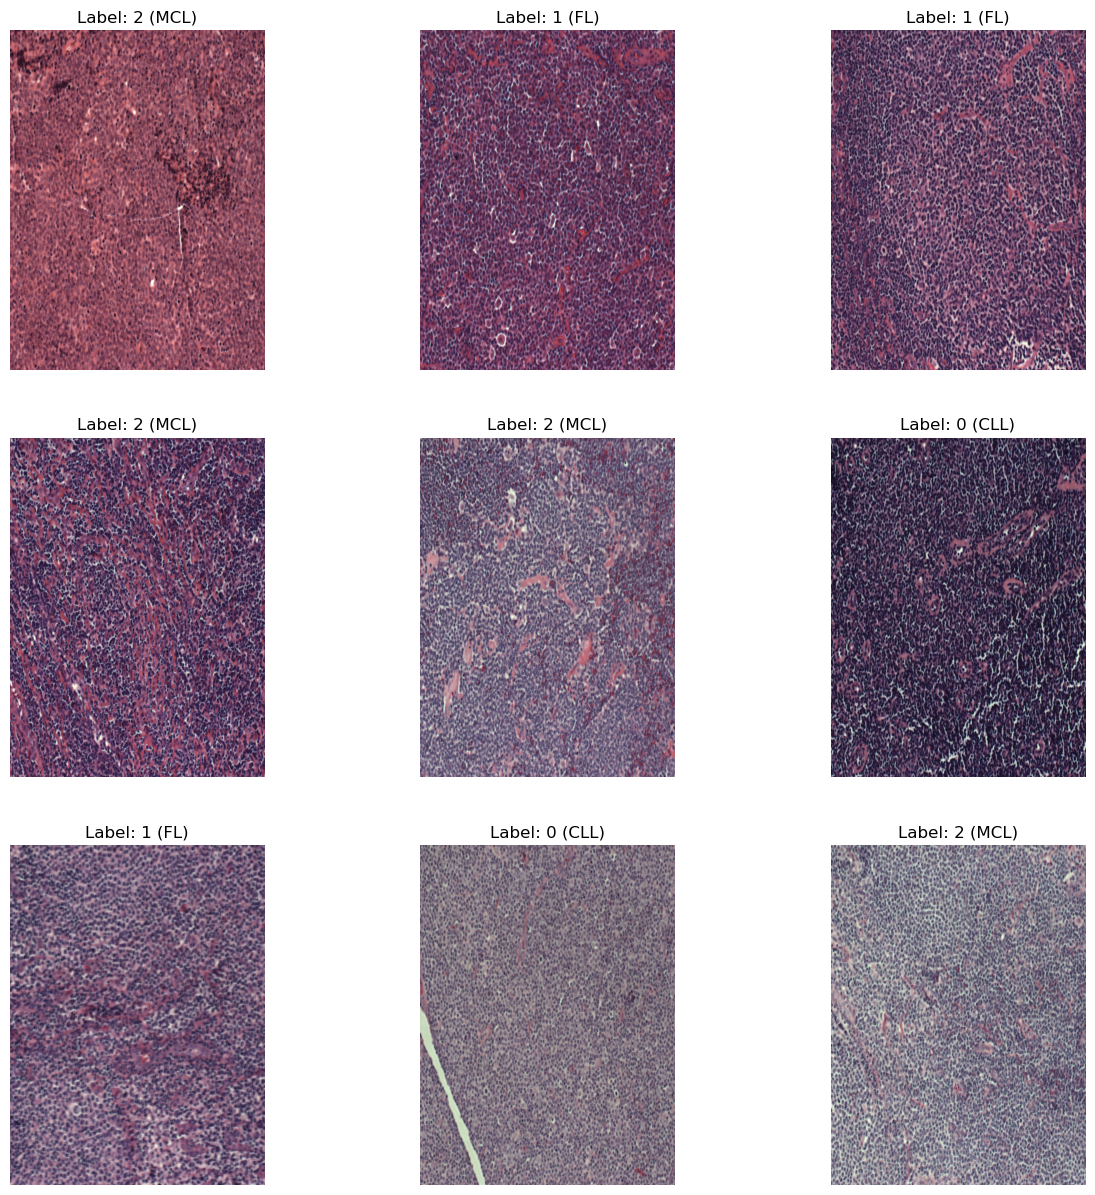

In [5]:
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()} ({class_names[labels[i].numpy()]})")
        plt.axis("off")

### Partición del conjunto de datos

In [6]:
X = []
y = []

for images, labels in dataset:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 1388, 1040, 3), (75, 1388, 1040, 3), (299,), (75,))

In [7]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
df_train = pd.DataFrame(X_train_flattened)
df_train['target'] = y_train
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4330551,4330552,4330553,4330554,4330555,4330556,4330557,4330558,4330559,target
0,129.665390,102.0,114.669228,125.992310,102.501923,120.007690,122.326920,108.855766,126.182693,131.711533,...,196.202026,200.326904,193.307617,188.992188,199.011719,199.003906,195.995850,187.673584,183.845093,2
1,98.836540,90.0,121.498077,108.019234,92.007690,120.003845,124.711533,104.875000,131.038452,131.657700,...,115.817261,108.797974,155.653809,131.455078,127.462891,160.992188,150.493774,146.159058,170.493774,0
2,83.669228,53.0,99.832695,90.513458,58.019230,102.011536,98.182693,72.201920,112.528847,106.026924,...,61.817261,27.490356,60.000000,65.003906,30.000000,61.494141,53.175659,29.167358,69.661133,2
3,130.498077,107.0,130.334610,124.988464,101.980766,128.486542,117.817307,91.980774,119.144234,111.946159,...,177.855835,150.875122,153.182739,162.537109,128.046875,141.529297,133.016602,100.179810,127.338867,0
4,94.000000,85.0,109.000000,100.023079,89.517311,113.517311,119.384613,107.384613,126.365387,139.855774,...,102.730957,73.365479,102.182739,83.011719,62.011719,97.003906,74.171509,58.167358,99.330566,0


Reordenaremos las columnas de manera que la variable target sea la primera

In [8]:
cols = list(df_train.columns)
cols.remove('target')
cols.insert(0,'target')
df_train = df_train.reindex(columns=cols)
df_train.head()

,target,0,1,2,3,4,5,6,7,8,...,4330550,4330551,4330552,4330553,4330554,4330555,4330556,4330557,4330558,4330559
0,2,129.665390,102.0,114.669228,125.992310,102.501923,120.007690,122.326920,108.855766,126.182693,...,194.657715,196.202026,200.326904,193.307617,188.992188,199.011719,199.003906,195.995850,187.673584,183.845093
1,0,98.836540,90.0,121.498077,108.019234,92.007690,120.003845,124.711533,104.875000,131.038452,...,151.684570,115.817261,108.797974,155.653809,131.455078,127.462891,160.992188,150.493774,146.159058,170.493774
2,2,83.669228,53.0,99.832695,90.513458,58.019230,102.011536,98.182693,72.201920,112.528847,...,58.828857,61.817261,27.490356,60.000000,65.003906,30.000000,61.494141,53.175659,29.167358,69.661133
3,0,130.498077,107.0,130.334610,124.988464,101.980766,128.486542,117.817307,91.980774,119.144234,...,169.315430,177.855835,150.875122,153.182739,162.537109,128.046875,141.529297,133.016602,100.179810,127.338867
4,0,94.000000,85.0,109.000000,100.023079,89.517311,113.517311,119.384613,107.384613,126.365387,...,119.738281,102.730957,73.365479,102.182739,83.011719,62.011719,97.003906,74.171509,58.167358,99.330566


In [9]:
df_train.iloc[:, :1000].describe().T

,count,mean,std,min,25%,50%,75%,max
target,299.0,1.026756,0.793823,0.000000,0.000000,1.000000,2.000000,2.000000
0,299.0,118.704758,39.785355,22.832693,90.501923,119.669228,146.834610,221.832687
1,299.0,95.618729,42.081516,16.000000,62.500000,91.000000,127.000000,232.000000
2,299.0,116.605637,33.356007,40.334614,92.834618,114.665382,142.167305,198.665390
3,299.0,118.353905,38.911190,22.501923,90.500000,117.980766,144.758652,223.007690
...,...,...,...,...,...,...,...,...
994,299.0,93.280426,41.553204,19.849976,63.749878,87.250366,121.274963,206.924988
995,299.0,115.054764,32.777767,45.549927,92.537506,115.150024,138.624939,200.075012
996,299.0,114.538040,38.848564,25.259613,88.629807,113.442322,141.923096,200.923096
997,299.0,93.527779,41.383114,19.961548,63.961548,87.288513,123.221161,209.701935


In [10]:
df_train['target'].value_counts()

target
1    111
2     98
0     90
Name: count, dtype: int64

In [11]:
def resize_images(X):
    resized = []
    
    for img in X:
        img_resized = tf.image.resize(img, (227, 227))
        resized.append(img_resized.numpy())
        
    return np.array(resized)

In [12]:
X_train = resize_images(X_train)
X_test = resize_images(X_test)

X_train.shape, X_test.shape

((299, 227, 227, 3), (75, 227, 227, 3))

In [13]:
X_train = X_train/255.0
X_test = X_test/255.0

## Entrenar la CNN

### AlexNet

In [14]:
def AlexNet():
    inp = layers.Input((227, 227, 3))
    x = layers.Conv2D(96, 11, 4, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Conv2D(256, 5, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Conv2D(384, 3, 1, activation='relu')(x)
    x = layers.Conv2D(384, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(3, activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)

    return model

In [15]:
model = AlexNet()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 23, 23, 256)      1024  

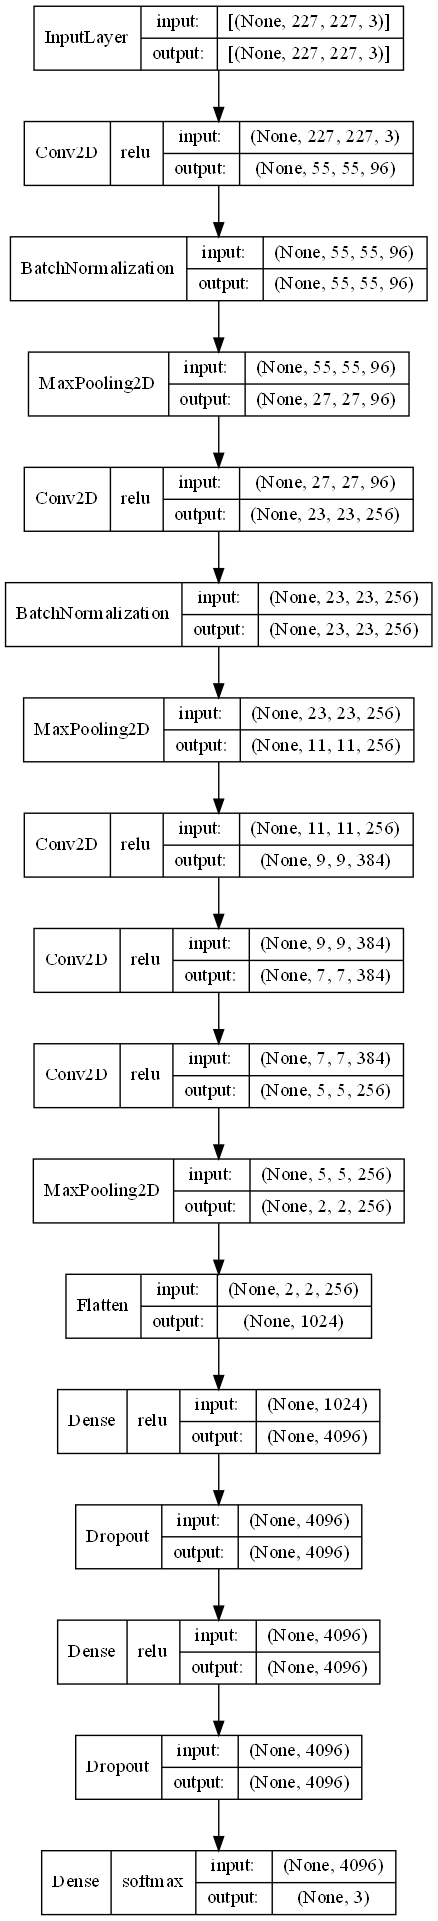

In [16]:
tf.keras.utils.plot_model(
    model,
    to_file = 'AlexNet.png',
    show_shapes = True,
    show_dtype = False,
    show_layer_names = False,
    show_layer_activations = True,
    dpi = 100
)

In [17]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [18]:
history = model.fit(X_train, y_train, epochs = 30)

Epoch 1/30
10/10 [==============================] - 9s 114ms/step - loss: 3.2053 - accuracy: 0.3880
Epoch 2/30
10/10 [==============================] - 0s 44ms/step - loss: 1.1529 - accuracy: 0.3746
Epoch 3/30
10/10 [==============================] - 0s 43ms/step - loss: 1.0662 - accuracy: 0.4950
Epoch 4/30
10/10 [==============================] - 0s 45ms/step - loss: 1.0293 - accuracy: 0.4582
Epoch 5/30
10/10 [==============================] - 0s 43ms/step - loss: 1.0989 - accuracy: 0.3478
Epoch 6/30
10/10 [==============================] - 0s 43ms/step - loss: 1.0985 - accuracy: 0.3645
Epoch 7/30
10/10 [==============================] - 0s 44ms/step - loss: 1.0968 - accuracy: 0.3712
Epoch 8/30
10/10 [==============================] - 0s 45ms/step - loss: 1.0974 - accuracy: 0.3712
Epoch 9/30
10/10 [==============================] - 0s 42ms/step - loss: 1.0951 - accuracy: 0.3712
Epoch 10/30
10/10 [==============================] - 0s 43ms/step - loss: 1.0957 - accuracy: 0.3712
Epoch 11

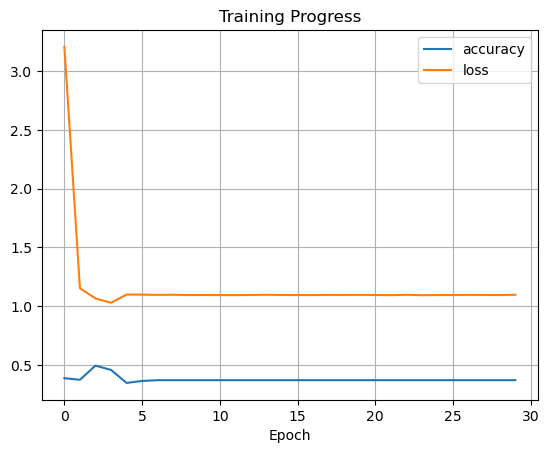

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.title('Training Progress')
plt.show()